In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP
from datasets import inputs, sf_inputs_discrete
from run_td_rnn import run as run_rnn
from run_td_mlp import run as run_mlp
from run_td_linear import run as run_linear
from utils import get_firing_field, get_field_metrics
import configs

device = 'cpu'

# Option A: Specify dataset and run network

In [ ]:
num_states = 20*20

In [ ]:
gamma=0.75

In [4]:
# N-hot inputs
feature_maker_kwargs = {
    'feature_dim': num_states*2, 'feature_type': 'nhot'
    }

# Correlated inputs
feature_maker_kwargs = {
    'feature_dim': num_states, 'feature_vals': None,
    'feature_vals_p': [0.975, 0.025],
    'feature_type': 'correlated_distributed',
    'spatial_sigma': 2.5, 'gaussian_truncate': 4.0
    }

dataset_config = {
    'num_steps': 6500, 'num_states': num_states,
    'feature_maker_kwargs': feature_maker_kwargs
    }
dataset = sf_inputs_discrete.Sim2DWalk


# dataset_config = {
#     'feature_maker_kwargs': feature_maker_kwargs,
#     'num_steps': np.inf
#     }
# dataset = sf_inputs_discrete.TitmouseWalk

input_size = feature_maker_kwargs['feature_dim']
seed = 3

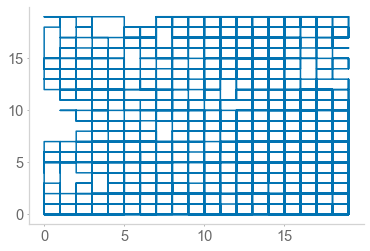

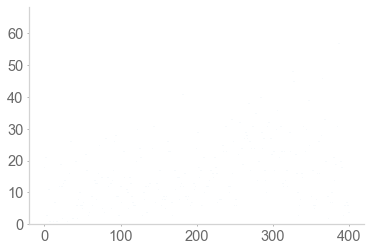

14.0


0.02

In [5]:
input = dataset(**dataset_config)
plt.figure();
plt.plot(input.xs, input.ys)
plt.show()

plt.figure();
states = np.argwhere(input.state_inputs)[:,0]
counts = np.zeros(input.num_states)
for state in np.arange(input.num_states):
    counts[state] = np.sum(states==state)
plt.bar(np.arange(input.num_states), counts)
plt.show()
print(np.median(counts))
np.sum(counts == 0)/input.num_states

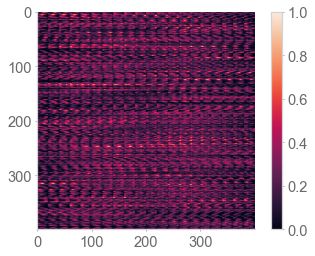

In [6]:
plt.figure()
plt.imshow(input.feature_maker.feature_map)
plt.colorbar()
plt.show()

0.22637756047128435
0.2268516914980325
False


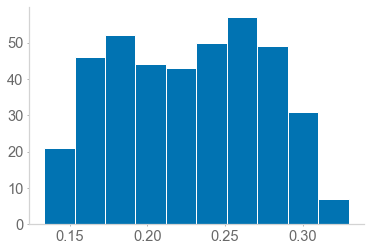

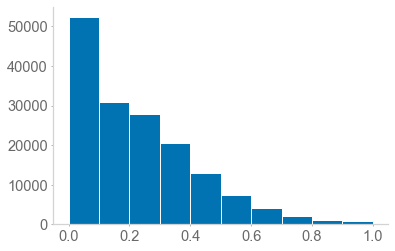

In [7]:
sparsities = []
for feat in input.feature_maker.feature_map.T:
    sparsities.append(np.sum(feat)/feat.size)
plt.hist(sparsities)
print(np.mean(sparsities))
print(np.median(sparsities))
print(0 in sparsities)

plt.figure()
plt.hist(input.feature_maker.feature_map.flatten())
plt.show()

In [8]:
arena_length = int(np.sqrt(input.num_states)) - 1
walk_xs = input.xs.astype(int)
walk_ys = input.ys.astype(int)

In [9]:
input.dg_inputs.shape

(400, 6500)

In [ ]:
rnn = AnalyticSR(
    num_states=input_size, gamma=gamma,
    ca3_kwargs={
        'use_dynamic_lr':False, 'lr': 1E-3,
        #'rollout':30
        #'parameterize': True,
        'alpha': 2., 'beta': 2.
        }
    )

outputs, loss, dset = run_rnn(
    '../trained_models/test/', rnn, dataset,
    dataset_config, gamma=gamma, test_over_all=False,
    train_net=False, return_dset=True
    )


[   51] loss: 0.061
Time per step 0.024s, net 1.200s

[  101] loss: 0.043
Time per step 0.026s, net 2.524s
SVD did not converge. Small values added on diagonal.
SVD did not converge. Small values added on diagonal.

[  151] loss: 0.037
Time per step 0.029s, net 3.977s

[  201] loss: 0.036
Time per step 0.028s, net 5.380s

[  251] loss: 0.036
Time per step 0.030s, net 6.882s

[  301] loss: 0.036
Time per step 0.029s, net 8.344s

[  351] loss: 0.037
Time per step 0.037s, net 10.204s

[  401] loss: 0.037
Time per step 0.031s, net 11.750s

[  451] loss: 0.038
Time per step 0.039s, net 13.682s

[  501] loss: 0.038
Time per step 0.039s, net 15.645s

[  551] loss: 0.038
Time per step 0.036s, net 17.426s

[  601] loss: 0.037
Time per step 0.035s, net 19.198s

[  651] loss: 0.036
Time per step 0.033s, net 20.844s
SVD did not converge. Small values added on diagonal.
SVD did not converge. Small values added on diagonal.
SVD did not converge. Small values added on diagonal.
SVD did not converge.

In [11]:
walk_xs = dset.xs
walk_ys = dset.ys
arena_length = int(np.sqrt(dset.num_states))

### Make Plots

In [12]:
from scipy import ndimage

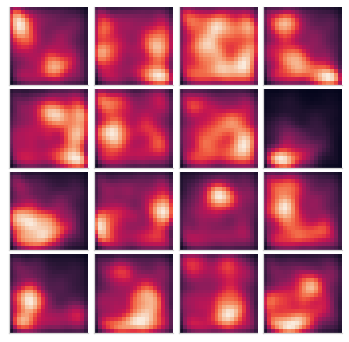

In [13]:
import matplotlib.gridspec as gridspec

grid_x = 4; grid_y = 4;

plt.figure(figsize = (6, 6))
gs1 = gridspec.GridSpec(grid_x, grid_y)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 

neurs = np.arange(outputs.shape[1])
np.random.shuffle(neurs)

idx = 0
for neur in neurs:
    ff, _ = get_firing_field(
        walk_xs, walk_ys, outputs[:,neur],
        arena_length, normalize=True
        )
    ax = plt.subplot(gs1[idx])
    plt.axis('on')
    ax.imshow(ff/ff.max(), vmin=0., vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])

    idx += 1
    if idx == grid_x*grid_y: break
plt.show()

### Metrics

In [14]:
fieldsize, nfield, onefield = get_field_metrics(outputs, dset, arena_length, nshuffles=30)

In [15]:
print(f'Fieldsize: {fieldsize}')
print(f'# Fields: {nfield}')
print(f'Ratio One Field: {onefield}')

Fieldsize: 0.07931267806267807
# Fields: 1.755
Ratio One Field: 0.395


In [16]:
fieldsize, nfield, onefield = get_field_metrics(outputs, dset, arena_length, nshuffles=50)

In [17]:
print(f'Fieldsize: {fieldsize}')
print(f'# Fields: {nfield}')
print(f'Ratio One Field: {onefield}')

Fieldsize: 0.07062409812409812
# Fields: 1.7325
Ratio One Field: 0.3975


In [18]:
fieldsize, nfield, onefield = get_field_metrics(outputs, dset, arena_length, nshuffles=100)

In [19]:
print(f'Fieldsize: {fieldsize}')
print(f'# Fields: {nfield}')
print(f'Ratio One Field: {onefield}')

Fieldsize: 0.06003997093023256
# Fields: 1.72
Ratio One Field: 0.4


# Option B: Load existing results

In [68]:
results_dirs = []
data_dir = '/home/chingf/engram/Ching/03_td_discrete_corr/'
desired_sigmas = ['sigma1.75', 'sigma2.0']
desired_sparsity_range = [0.1, 0.19]
for sparsity in os.listdir(data_dir):
    if not os.path.isdir(f'{data_dir}{sparsity}'): continue
    sigma_dirs = os.listdir(f'{data_dir}{sparsity}')
    for desired_sigma in desired_sigmas:
        if desired_sigma in sigma_dirs:
            results_dir = f'{data_dir}{sparsity}/{desired_sigma}/0.4/rnn/0/'
            results_path = results_dir + 'results.p'
            with open(results_path, 'rb') as f:
                results = pickle.load(f)
            dset = results['dset']
            final_sparsity = dset.feature_maker.post_smooth_sparsity
            if final_sparsity >= desired_sparsity_range[0]:
                if final_sparsity <= desired_sparsity_range[1]:
                    results_dirs.append(results_dir)

In [69]:
print(len(results_dirs))
results_dirs

25


['/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.019526315789473683/sigma1.75/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03573684210526316/sigma1.75/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.031105263157894733/sigma1.75/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03178947368421053/sigma2.0/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.017210526315789475/sigma1.75/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03342105263157895/sigma1.75/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021526315789473685/sigma2.0/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021842105263157892/sigma1.75/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.023578947368421053/sigma2.0/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.01536842105263158/sigma2.0/0.4/rnn/0/',
 '/home/

In [8]:
print(len(results_dirs))
results_dirs

24


['/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.019526315789473683/sigma1.75/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03573684210526316/sigma1.75/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.031105263157894733/sigma1.75/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03178947368421053/sigma2.0/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.017210526315789475/sigma1.75/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03342105263157895/sigma1.75/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021526315789473685/sigma2.0/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021842105263157892/sigma1.75/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.023578947368421053/sigma2.0/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.01536842105263158/sigma2.0/0.8/rnn/0/',
 '/home/

In [48]:
# results_dir = '/home/chingf/engram/Ching/03_td_discrete_corr/' + \
#     'sparsity0.03178947368421053/sigma2.0/0.8/rnn/0/'

In [79]:
results_dir = '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021526315789473685/sigma2.0/0.4/rnn/0/'

In [80]:
results_path = results_dir + 'results.p'
fieldinfos_path = results_dir + 'field_infos.p'
with open(results_path, 'rb') as f:
    results = pickle.load(f)
if os.path.isfile(fieldinfos_path):
    with open(fieldinfos_path, 'rb') as f:
        fieldinfos = pickle.load(f)
if 'hopfield' in results_path:
    outputs = results['outputs'].detach().numpy().squeeze()
else:
    outputs = results['outputs']
dset = results['dset']

print('Sigma:')
print(dset.feature_maker.spatial_sigma)
print('Sparsity:')
print(dset.feature_maker.post_smooth_sparsity)

Sigma:
2.0
Sparsity:
0.12936946882376868


In [81]:
walk_xs = dset.xs
walk_ys = dset.ys
arena_length = int(np.sqrt(outputs.shape[1]))

### Make Plots

In [82]:
from scipy import ndimage
import matplotlib.gridspec as gridspec

In [84]:
def plot_fields(results_dir):
    results_path = results_dir + 'results.p'
    fieldinfos_path = results_dir + 'field_infos.p'
    with open(results_path, 'rb') as f:
        results = pickle.load(f)
    if os.path.isfile(fieldinfos_path):
        with open(fieldinfos_path, 'rb') as f:
            fieldinfos = pickle.load(f)
    if 'hopfield' in results_path:
        outputs = results['outputs'].detach().numpy().squeeze()
    else:
        outputs = results['outputs']
    dset = results['dset']

    print('Sigma:')
    print(dset.feature_maker.spatial_sigma)
    print('Sparsity:')
    print(dset.feature_maker.post_smooth_sparsity)

    walk_xs = dset.xs
    walk_ys = dset.ys
    arena_length = int(np.sqrt(outputs.shape[1]))

    grid_x = 4; grid_y = 4;

    plt.figure(figsize = (6, 6))
    gs1 = gridspec.GridSpec(grid_x, grid_y)
    gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 

    neurs = np.arange(outputs.shape[1])
    np.random.shuffle(neurs)

    idx = 0
    for neur in neurs:
        ff, mask = get_firing_field(
            walk_xs, walk_ys, outputs[:,neur],
            arena_length, normalize=True
            )
        ax = plt.subplot(gs1[idx])
        plt.axis('on')
        if np.sum(fieldinfos[neur][1]) == 0: continue # Skip non-place cells
        ff = ff - ff.min()
        #ff *= fieldinfos[neur][1]
        ax.imshow(ff/ff.max(), vmin=0., vmax=1, cmap='viridis')
        ax.set_xticks([])
        ax.set_yticks([])

        idx += 1
        if idx == grid_x*grid_y: break
    plt.suptitle('Simulated Place Fields')
    plt.tight_layout()
    plt.savefig('5c_fields', dpi=300)
    plt.show()

In [85]:
# Results dir for gamma=0.4
rd_04 = ['/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.019526315789473683/sigma1.75/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03573684210526316/sigma1.75/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.031105263157894733/sigma1.75/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03178947368421053/sigma2.0/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.017210526315789475/sigma1.75/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03342105263157895/sigma1.75/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021526315789473685/sigma2.0/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021842105263157892/sigma1.75/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.023578947368421053/sigma2.0/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.01536842105263158/sigma2.0/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.035894736842105264/sigma2.0/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.014894736842105263/sigma1.75/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.025631578947368422/sigma2.0/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.038052631578947366/sigma1.75/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.02768421052631579/sigma2.0/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.019473684210526317/sigma2.0/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.033842105263157896/sigma2.0/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.02973684210526316/sigma2.0/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.024157894736842104/sigma1.75/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03794736842105263/sigma2.0/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.028789473684210524/sigma1.75/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.026473684210526316/sigma1.75/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.017421052631578948/sigma2.0/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.04/sigma2.0/0.4/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.013315789473684211/sigma2.0/0.4/rnn/0/']

In [86]:
# Results dir for gamma=0.8
rd_08 = ['/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.019526315789473683/sigma1.75/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03573684210526316/sigma1.75/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.031105263157894733/sigma1.75/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03178947368421053/sigma2.0/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.017210526315789475/sigma1.75/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03342105263157895/sigma1.75/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021526315789473685/sigma2.0/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021842105263157892/sigma1.75/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.023578947368421053/sigma2.0/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.01536842105263158/sigma2.0/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.04268421052631578/sigma1.75/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.035894736842105264/sigma2.0/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.014894736842105263/sigma1.75/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.025631578947368422/sigma2.0/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.038052631578947366/sigma1.75/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.02768421052631579/sigma2.0/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.019473684210526317/sigma2.0/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.033842105263157896/sigma2.0/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.02973684210526316/sigma2.0/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.024157894736842104/sigma1.75/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.028789473684210524/sigma1.75/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.026473684210526316/sigma1.75/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.017421052631578948/sigma2.0/0.8/rnn/0/',
 '/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.013315789473684211/sigma2.0/0.8/rnn/0/']

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.019526315789473683/sigma1.75/0.4/rnn/0/
Sigma:
1.75
Sparsity:
0.1296369450302725


/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


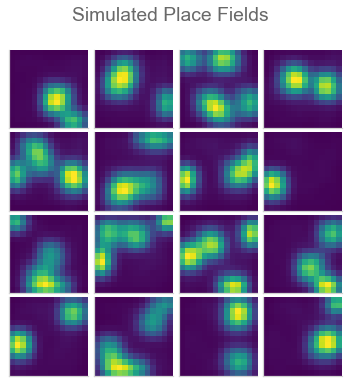

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03573684210526316/sigma1.75/0.4/rnn/0/
Sigma:
1.75
Sparsity:
0.18172258922755924


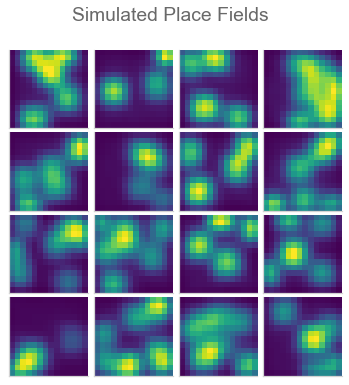

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.031105263157894733/sigma1.75/0.4/rnn/0/
Sigma:
1.75
Sparsity:
0.16624441618098496


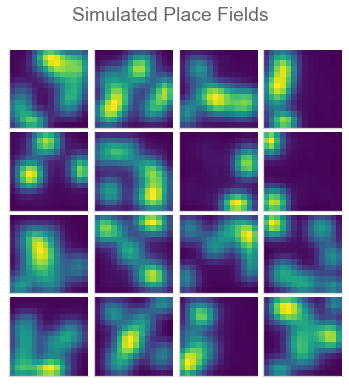

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03178947368421053/sigma2.0/0.4/rnn/0/
Sigma:
2.0
Sparsity:
0.16966018972384375


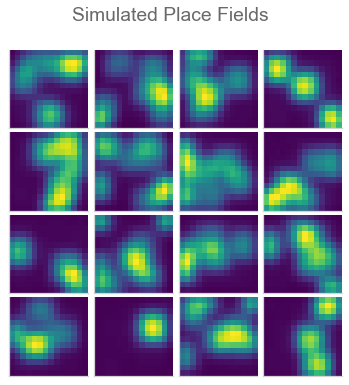

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.017210526315789475/sigma1.75/0.4/rnn/0/
Sigma:
1.75
Sparsity:
0.1169572677813416


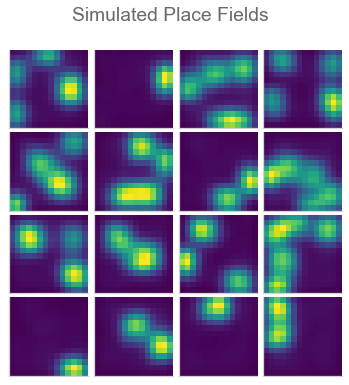

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03342105263157895/sigma1.75/0.4/rnn/0/
Sigma:
1.75
Sparsity:
0.17075223076087792


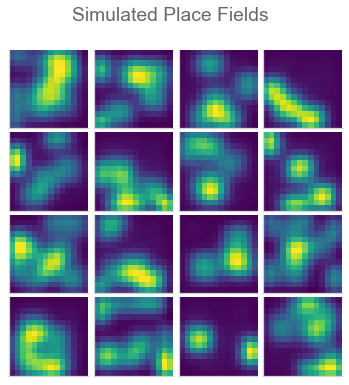

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021526315789473685/sigma2.0/0.4/rnn/0/
Sigma:
2.0
Sparsity:
0.12936946882376868


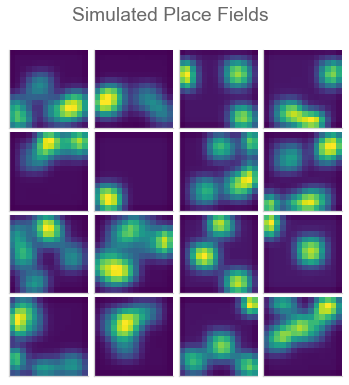

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021842105263157892/sigma1.75/0.4/rnn/0/
Sigma:
1.75
Sparsity:
0.13828643421501985


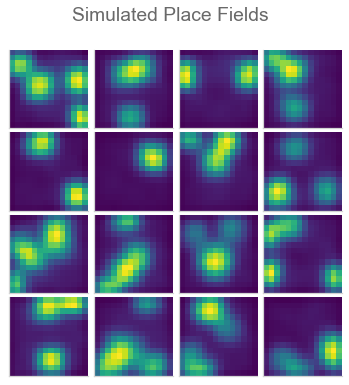

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.023578947368421053/sigma2.0/0.4/rnn/0/
Sigma:
2.0
Sparsity:
0.14162367858871303


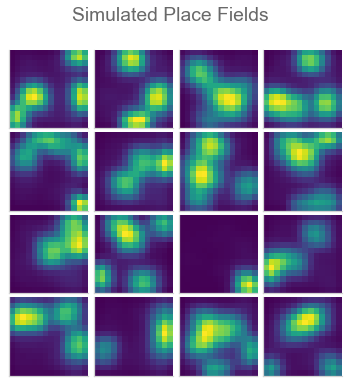

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.01536842105263158/sigma2.0/0.4/rnn/0/
Sigma:
2.0
Sparsity:
0.11423683926211611


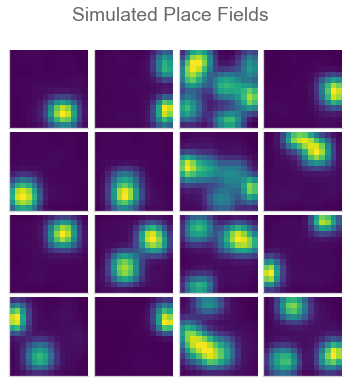

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.035894736842105264/sigma2.0/0.4/rnn/0/
Sigma:
2.0
Sparsity:
0.1835346135419133


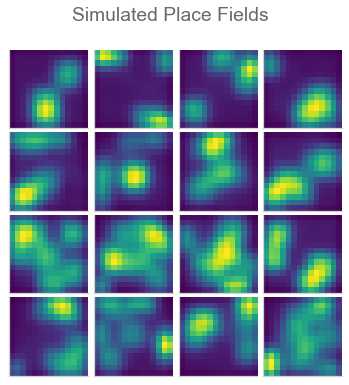

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.014894736842105263/sigma1.75/0.4/rnn/0/
Sigma:
1.75
Sparsity:
0.10387817278041855


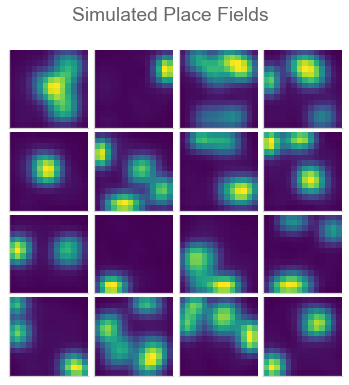

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.025631578947368422/sigma2.0/0.4/rnn/0/
Sigma:
2.0
Sparsity:
0.15739821736055853


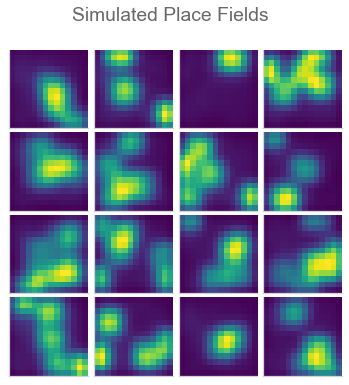

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.038052631578947366/sigma1.75/0.4/rnn/0/
Sigma:
1.75
Sparsity:
0.17256385316725115


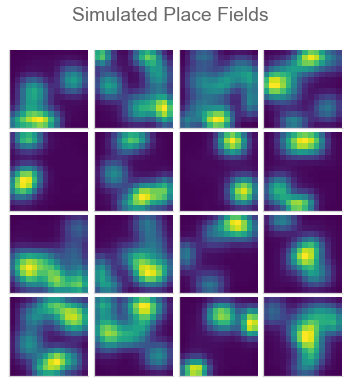

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.02768421052631579/sigma2.0/0.4/rnn/0/
Sigma:
2.0
Sparsity:
0.15529478882286932


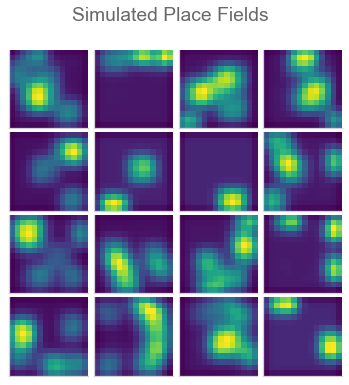

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.019473684210526317/sigma2.0/0.4/rnn/0/
Sigma:
2.0
Sparsity:
0.13563918740543093


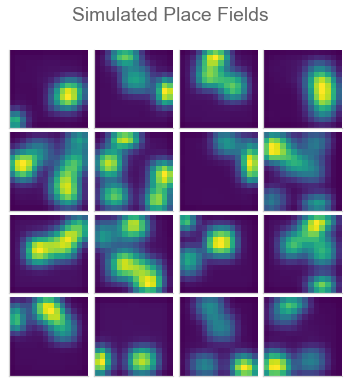

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.033842105263157896/sigma2.0/0.4/rnn/0/
Sigma:
2.0
Sparsity:
0.17199557476891705


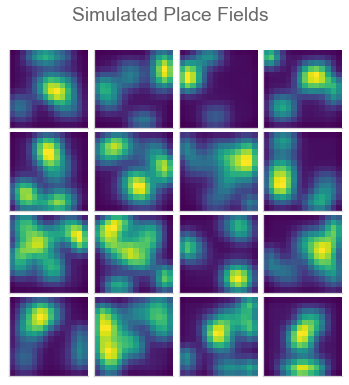

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.02973684210526316/sigma2.0/0.4/rnn/0/
Sigma:
2.0
Sparsity:
0.1629259391049629


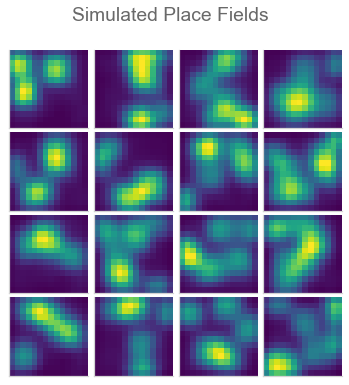

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.024157894736842104/sigma1.75/0.4/rnn/0/
Sigma:
1.75
Sparsity:
0.13424799391172226


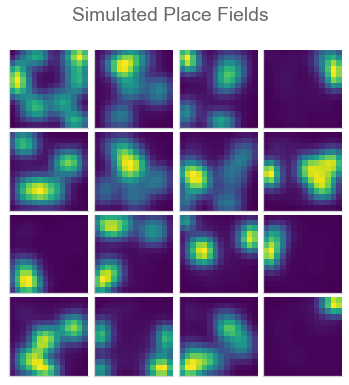

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03794736842105263/sigma2.0/0.4/rnn/0/
Sigma:
2.0
Sparsity:
0.16951895453553645


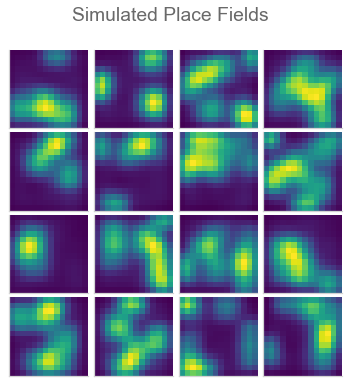

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.028789473684210524/sigma1.75/0.4/rnn/0/
Sigma:
1.75
Sparsity:
0.15310447113089298


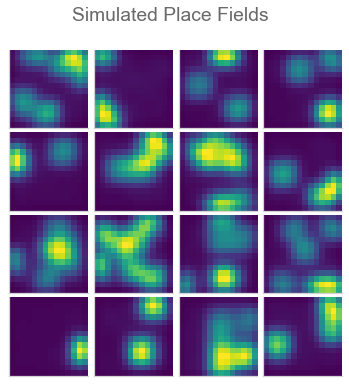

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.026473684210526316/sigma1.75/0.4/rnn/0/
Sigma:
1.75
Sparsity:
0.141738367563418


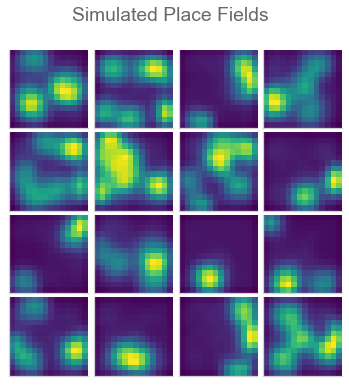

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.017421052631578948/sigma2.0/0.4/rnn/0/
Sigma:
2.0
Sparsity:
0.11593743556156319


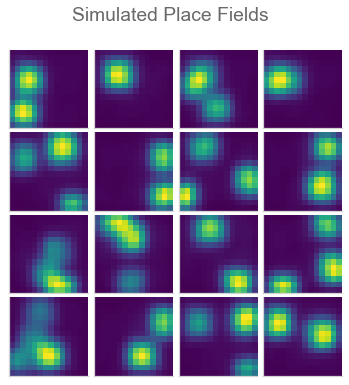

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.04/sigma2.0/0.4/rnn/0/
Sigma:
2.0
Sparsity:
0.18131664967592476


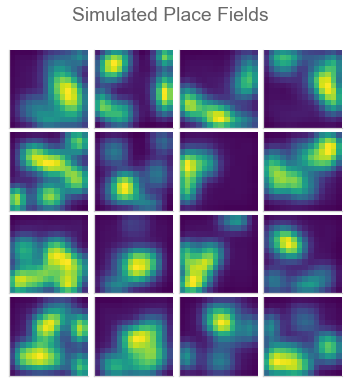

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.013315789473684211/sigma2.0/0.4/rnn/0/
Sigma:
2.0
Sparsity:
0.10314547076523412


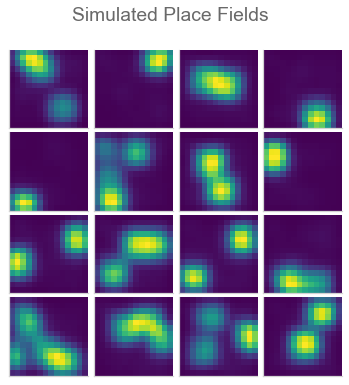

In [87]:
for x in rd_04:
    print(x)
    plot_fields(x)

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.019526315789473683/sigma1.75/0.8/rnn/0/
Sigma:
1.75
Sparsity:
0.13017977622454258


/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


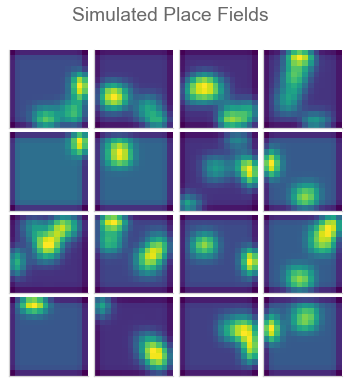

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03573684210526316/sigma1.75/0.8/rnn/0/
Sigma:
1.75
Sparsity:
0.17260926584438385


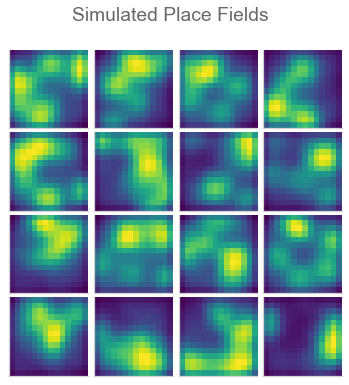

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.031105263157894733/sigma1.75/0.8/rnn/0/
Sigma:
1.75
Sparsity:
0.15686330921906735


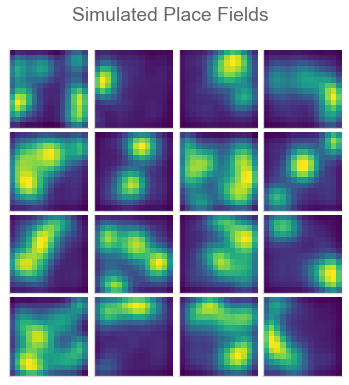

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03178947368421053/sigma2.0/0.8/rnn/0/
Sigma:
2.0
Sparsity:
0.16021853578602335


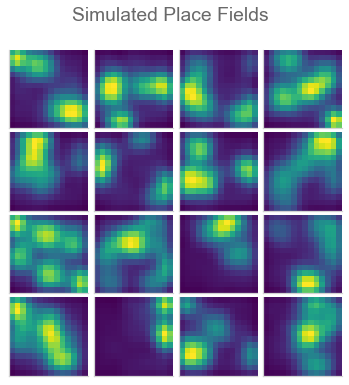

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.017210526315789475/sigma1.75/0.8/rnn/0/
Sigma:
1.75
Sparsity:
0.11476652836901916


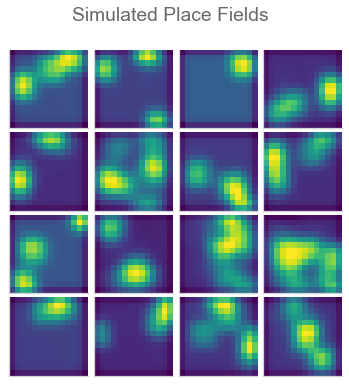

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.03342105263157895/sigma1.75/0.8/rnn/0/
Sigma:
1.75
Sparsity:
0.17748386219489706


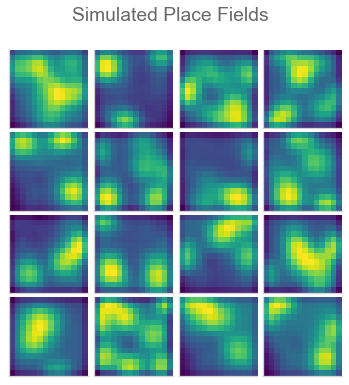

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021526315789473685/sigma2.0/0.8/rnn/0/
Sigma:
2.0
Sparsity:
0.13405883857686116


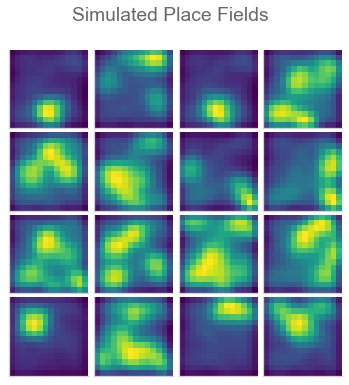

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.021842105263157892/sigma1.75/0.8/rnn/0/
Sigma:
1.75
Sparsity:
0.1241525077033741


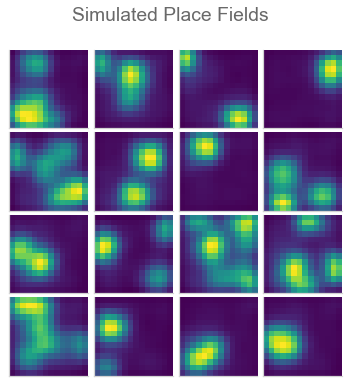

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.023578947368421053/sigma2.0/0.8/rnn/0/
Sigma:
2.0
Sparsity:
0.1511079930887434


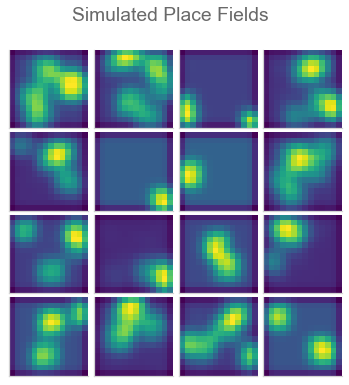

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.01536842105263158/sigma2.0/0.8/rnn/0/
Sigma:
2.0
Sparsity:
0.11266860341623995


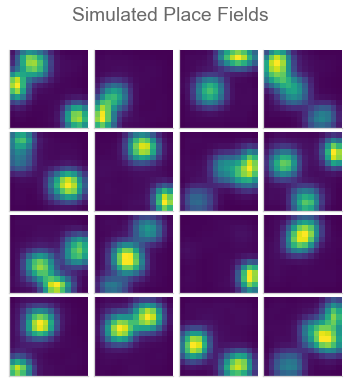

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.04268421052631578/sigma1.75/0.8/rnn/0/
Sigma:
1.75
Sparsity:
0.18724971181028144


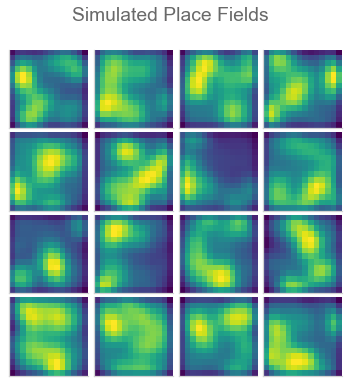

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.035894736842105264/sigma2.0/0.8/rnn/0/
Sigma:
2.0
Sparsity:
0.1743190775915574


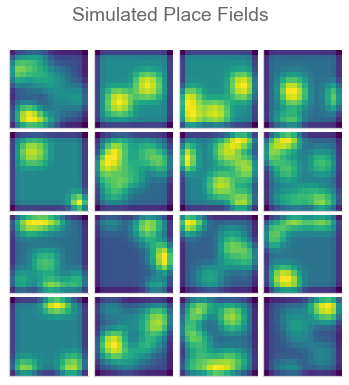

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.014894736842105263/sigma1.75/0.8/rnn/0/
Sigma:
1.75
Sparsity:
0.10059302881187784


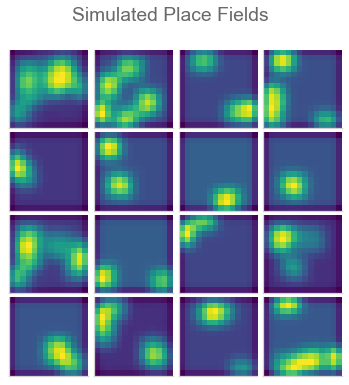

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.025631578947368422/sigma2.0/0.8/rnn/0/
Sigma:
2.0
Sparsity:
0.14870462657248146


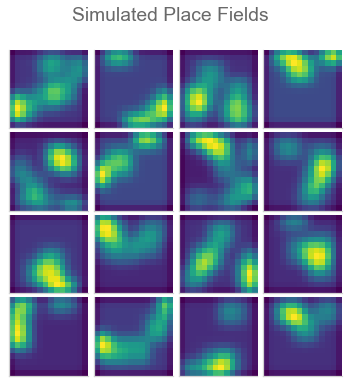

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.038052631578947366/sigma1.75/0.8/rnn/0/
Sigma:
1.75
Sparsity:
0.17075728446225097


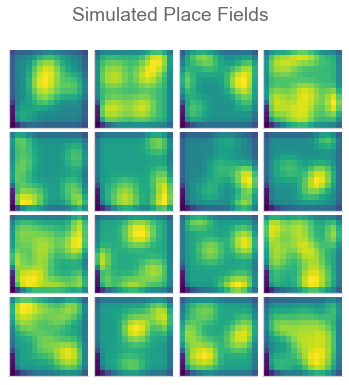

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.02768421052631579/sigma2.0/0.8/rnn/0/
Sigma:
2.0
Sparsity:
0.15667181897537116


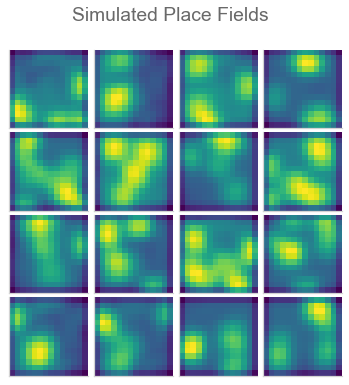

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.019473684210526317/sigma2.0/0.8/rnn/0/
Sigma:
2.0
Sparsity:
0.12339987845558423


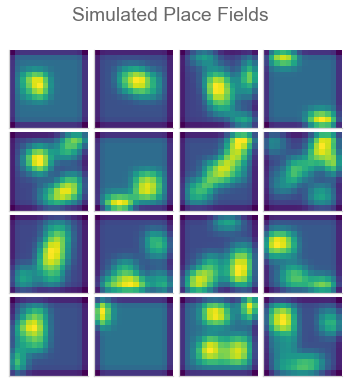

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.033842105263157896/sigma2.0/0.8/rnn/0/
Sigma:
2.0
Sparsity:
0.17615797652275716


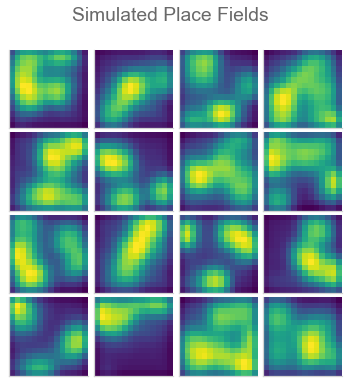

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.02973684210526316/sigma2.0/0.8/rnn/0/
Sigma:
2.0
Sparsity:
0.16946662701880286


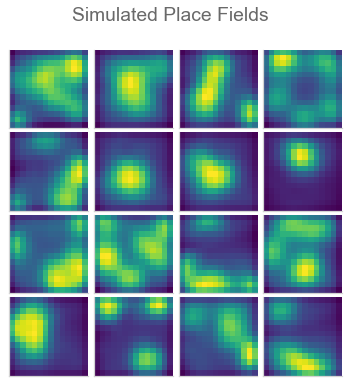

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.024157894736842104/sigma1.75/0.8/rnn/0/
Sigma:
1.75
Sparsity:
0.14110917256291794


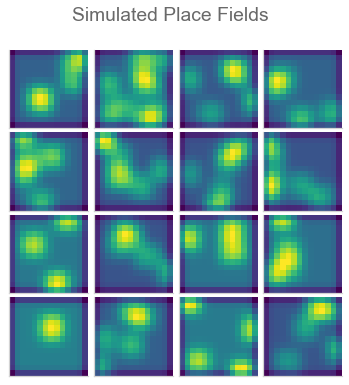

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.028789473684210524/sigma1.75/0.8/rnn/0/
Sigma:
1.75
Sparsity:
0.1648558810783327


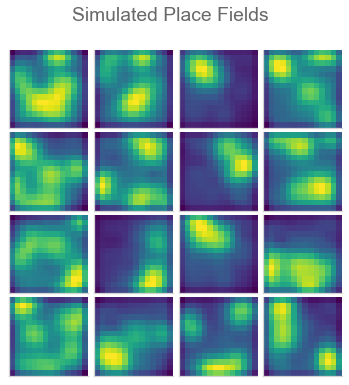

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.026473684210526316/sigma1.75/0.8/rnn/0/
Sigma:
1.75
Sparsity:
0.12898822132975812


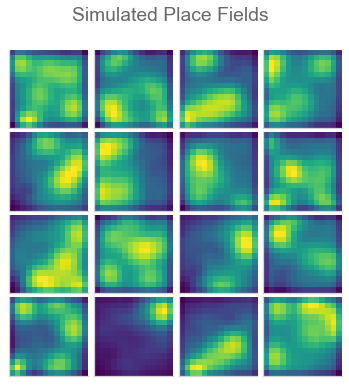

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.017421052631578948/sigma2.0/0.8/rnn/0/
Sigma:
2.0
Sparsity:
0.11644539812416155


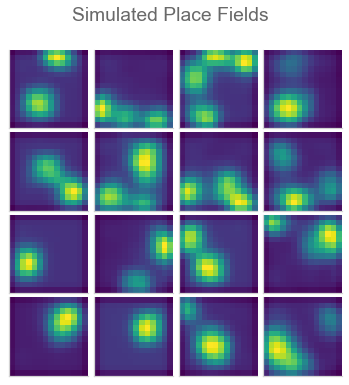

/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.013315789473684211/sigma2.0/0.8/rnn/0/
Sigma:
2.0
Sparsity:
0.10273825033470624


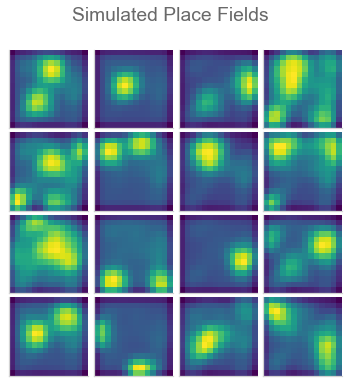

In [88]:
for x in rd_08:
    print(x)
    plot_fields(x)

Sigma:
2.0
Sparsity:
0.09851999981673576


/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


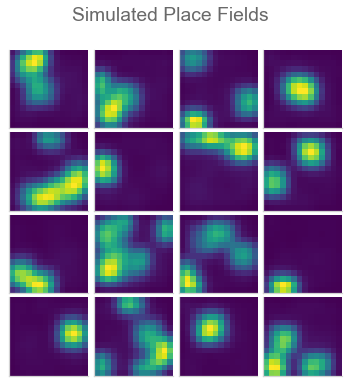

In [111]:
plot_fields('/home/chingf/engram/Ching/03_td_discrete_corr/sparsity0.01536842105263158/sigma2.0/0.4/rnn/2/')

### Metrics

In [59]:
fieldsize, nfield, onefield = get_field_metrics(outputs, dset, arena_length, nshuffles=10)

In [60]:
print(f'Fieldsize: {fieldsize}')
print(f'# Fields: {nfield}')
print(f'Ratio One Field: {onefield}')

Fieldsize: 0.05999538319482919
# Fields: 2.7075
Ratio One Field: 0.0875
